<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# Estudio comparativo de algoritmos en un problema de bandido de k-brazos


**Introducción al Algoritmo UCB1 y UCB2 para el Problema del Bandido Multibrazos**

Los algoritmos UCB1 y UCB2 están diseñados para equilibrar la exploración y la explotación en el contexto del problema del bandido multibrazos. A lo largo de múltiples ejecuciones y pasos, estos algoritmos intentan identificar el brazo óptimo, pero también exploran otros brazos con el objetivo de reducir la incertidumbre sobre sus recompensas potenciales.
- **UCB1**

Calcula una estimación de la recompensa para cada brazo y ajusta esta estimación según la incertidumbre sobre los brazos no explorados, favoreciendo aquellos con menos pruebas. La idea es que, a medida que más información sobre los brazos se va acumulando, se reduce la incertidumbre y se puede tomar decisiones más fundamentadas.  

- **UCB2**

Mientras que UCB1 utiliza una penalización basada en el logaritmo del tiempo total de iteración, UCB2 ajusta esta penalización utilizando el logaritmo del logaritmo del tiempo. Esto hace que UCB2 sea más conservador en la exploración, favoreciendo la explotación más rápidamente que UCB1. 

**Comparativa entre UCB1 y UCB2**

| Característica               | **UCB1**                               | **UCB2**                                  |
|------------------------------|----------------------------------------|-------------------------------------------|
| **Fórmula de exploración**    | \( \sqrt{\frac{2 \ln t}{n_a}} \)       | \( \sqrt{\frac{2 \ln (\ln t)}{n_a}} \)    |
| **Exploración vs Explotación**| Equilibrio estándar                    | Penalización más suave de exploración     |
| **Velocidad de Convergencia** | Más lenta en algunos casos             | Más rápida debido a la menor penalización |
| **Escenarios ideales**        | Ideal cuando la exploración debe ser moderada | Mejor para tareas con baja necesidad de exploración |

## Preparación del entorno

**Clonación del repositorio:**

Para poder acceder a todas las clases y métodos necesarios.

In [1]:
# !git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

In [2]:
# %cd k_brazos_FJLGM

### Librerías

In [3]:
import numpy as np
from typing import List

from src_algorithms import Algorithm,  UCB2, UCB1
from src_arms import *
from src_plotting import *

Semilla:

In [4]:
seed = 1234

**Definición del experimento:**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número determinado de pasos de tiempo y ejecuciones. Se comparan los resultados de los algoritmos en términos de recompensa promedio obtenida a lo largo de las ejecuciones.

Por ejemplo, dado un bandido de k brazos, se ejecutan dos algoritmos UCB1 y dos UCB2 con diferentes configuraciones de penalización en la exploración. El experimento se realiza durante un número de pasos, por ejemplo, 1000 pasos. Luego, se repite el experimento varias veces, como 500 ejecuciones, para obtener resultados consistentes. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso, se calcula el promedio de las recompensas obtenidas durante esas 500 ejecuciones.

In [5]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))


    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100

    return rewards, optimal_selections

**Ejecución del experimento**:

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial de probabilidad **n** y **p**. 

Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan dos algoritmos de la familia de **UCB**: 

- *UCB1*
- *UCB2*.

In [6]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 2 algoritmos UCB1 y 2 algoritmos UCB2 con diferentes valores.
algorithms = [UCB2(k=k, alpha_param=0.2),UCB2(k=k, alpha_param=0.9),UCB1(k=k, c=0.5),UCB1(k=k, c=1.5)] #, GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.4)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=8, p=0.25), ArmBinomial(n=17, p=0.75), ArmBinomial(n=11, p=0.79), ArmBinomial(n=13, p=0.32), ArmBinomial(n=18, p=0.75), ArmBinomial(n=18, p=0.49), ArmBinomial(n=17, p=0.67), ArmBinomial(n=14, p=0.14), ArmBinomial(n=8, p=0.12), ArmBinomial(n=9, p=0.81)
Optimal arm: 5 with expected reward=13.5


#### **Visualización de resultados**:

- Recompensa Promedio vs Pasos de Tiempo
- Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo

### Recompensa Promedio vs Pasos de Tiempo

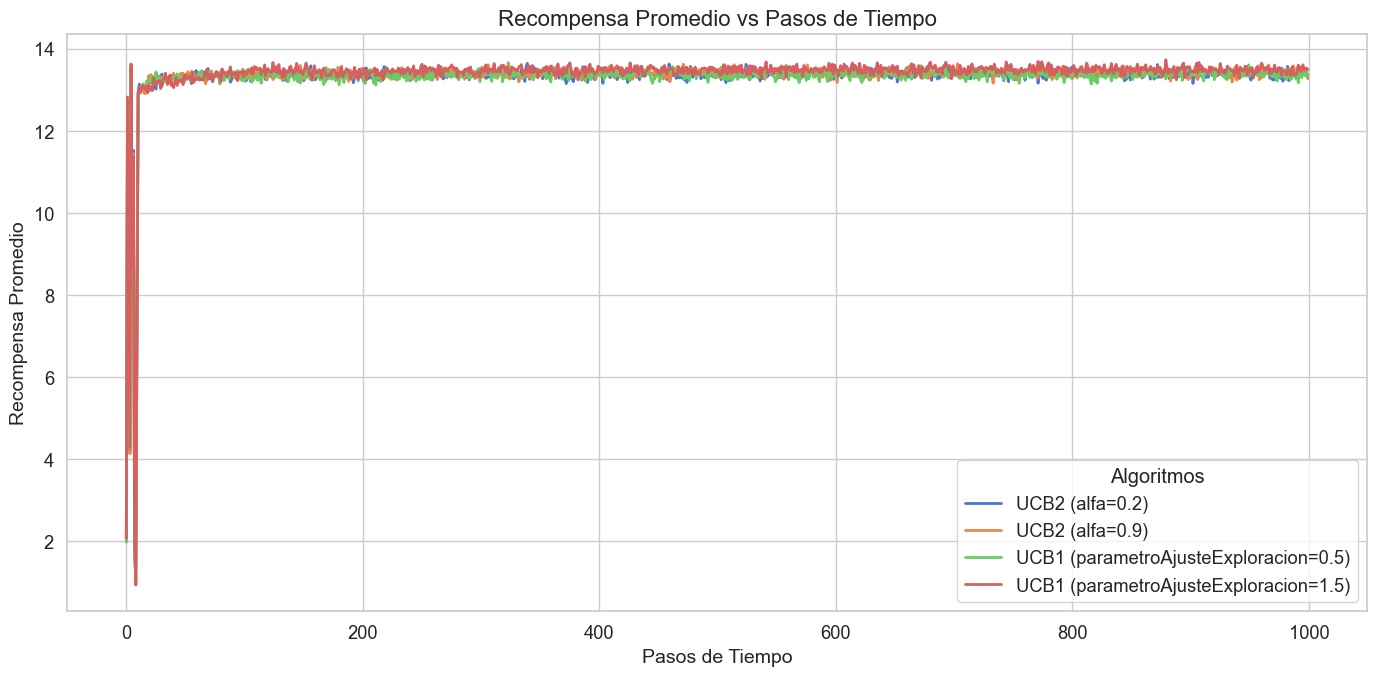

In [7]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)

**Recompensa Promedio vs Pasos de Tiempo**

En esta gráfica se analizan cuatro variantes del algoritmo **UCB** (Upper Confidence Bound) aplicadas a un problema de Bandido Multibrazos.

**Ejes**  
- **Eje X**: Representa los pasos o iteraciones (de 0 a 1000).  
- **Eje Y**: Muestra la recompensa promedio acumulada por cada variante de UCB (en un rango aproximado de 0 a 14).

**Línea Azul: UCB2 (α = 0.2)**  
- Ajusta la exploración con épocas relativamente cortas (α = 0.2).  
- Tras un breve periodo inicial de exploración (en torno a los primeros 50–100 pasos), alcanza recompensas promedio cercanas a **13** y mantiene un nivel muy estable.

**Línea Naranja: UCB2 (α = 0.9)**  
- Emplea épocas más largas (α = 0.9), aumentando la exploración.  
- Tiende a presentar oscilaciones algo mayores al inicio, pero finalmente converge a valores cercanos a **13–13.5**, muy similares a la línea azul.

**Línea Verde: UCB1 (c = 0.5)**  
- Reduce la bonificación de exploración (c=0.5), facilitando la explotación temprana del mejor brazo.  
- En la gráfica, **logra la mejor recompensa promedio**, situándose ligeramente por encima de **13.5**.

**Línea Roja: UCB1 (c = 1.5)**  
- Aumenta la bonificación de exploración (c=1.5), lo que puede retrasar la explotación del mejor brazo.  
- Se estabiliza alrededor de **13–13.2**, un poco por debajo del resto.

**Observaciones Destacadas**  
- **Mejor Desempeño**: El **UCB1 (c = 0.5)** (verde) mantiene la recompensa promedio más alta, demostrando que una exploración moderada puede acelerar la convergencia al mejor brazo en este entorno.  
- **Similitud entre UCB2(α=0.2) y UCB2(α=0.9)**: Ambas líneas (azul y naranja) se ubican cerca de 13–13.5, mostrando que, a largo plazo, la diferencia en la duración de las épocas no genera una brecha muy grande.  
- **Exceso de Exploración**: El **UCB1 (c = 1.5)** (rojo) se mantiene ligeramente por debajo de las demás variantes, posiblemente por un ajuste que sobrevalora la exploración.

**Conclusión General**  
Todos los algoritmos convergen a recompensas promedio muy altas, entre **13 y 14**, confirmando la eficacia de UCB en la identificación y explotación del mejor brazo. Ajustar el parámetro de exploración sigue siendo esencial para lograr la **máxima** recompensa en el menor número de pasos.


### Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo

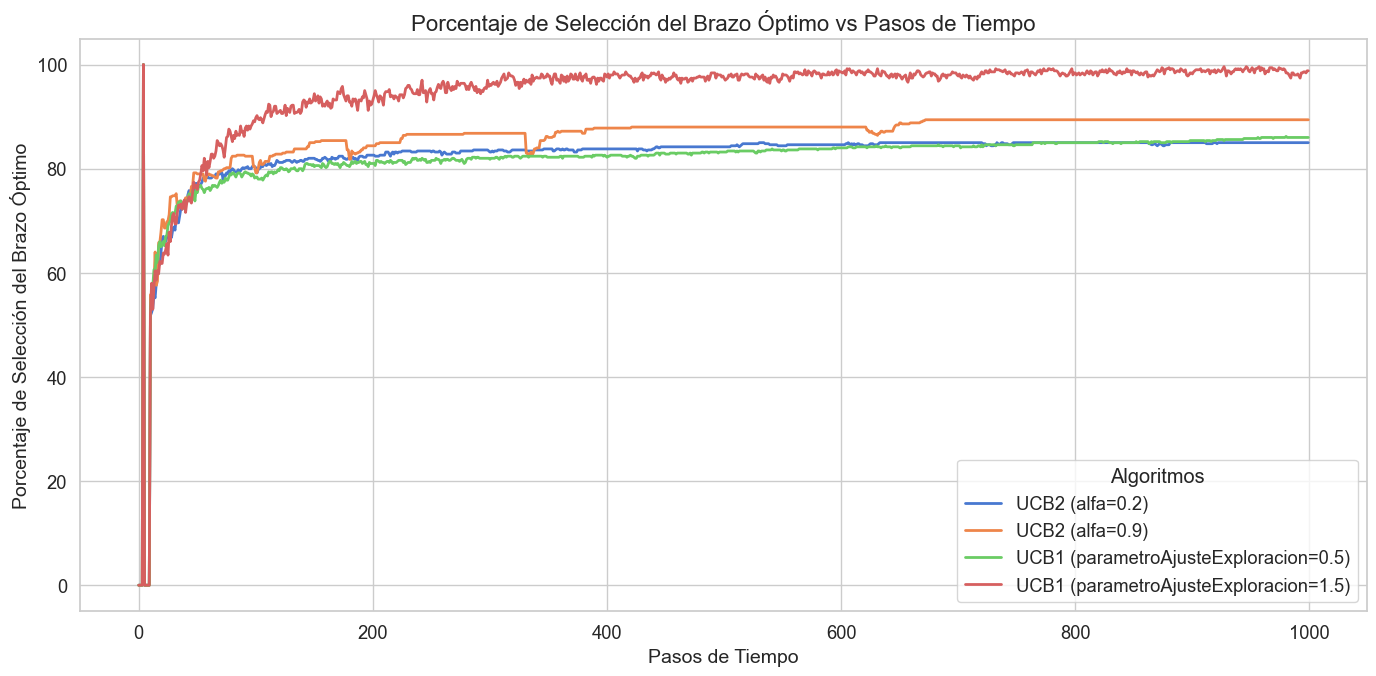

In [8]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**

Esta gráfica muestra la **frecuencia** (en porcentaje) con la que cada variante de UCB (Upper Confidence Bound) selecciona el **brazo óptimo** a lo largo de 1000 pasos.

**Ejes**  
- **Eje X**: Pasos o iteraciones (de 0 a 1000).  
- **Eje Y**: Porcentaje de veces que se elige el brazo óptimo (de 0% a 100%).

**Línea Azul: UCB2 (α = 0.2)**  
- Usa épocas de exploración relativamente cortas.  
- A medida que pasan las jugadas, incrementa su selección del brazo óptimo y supera el 90% en la parte final.

**Línea Naranja: UCB2 (α = 0.9)**  
- Emplea épocas más largas (más exploración).  
- Tiende a mostrar variaciones más notables al principio, pero se acerca también a valores elevados, rondando el 95% de selección óptima al final.

**Línea Verde: UCB1 (c = 0.5)**  
- Explora menos (c=0.5), lo que le permite enfocarse antes en el mejor brazo.  
- En esta gráfica, **alcanza cerca del 100%** de selección del brazo óptimo, lo que indica una rápida y sólida convergencia.

**Línea Roja: UCB1 (c = 1.5)**  
- Aumenta la bonificación de exploración (c=1.5), lo que puede retrasar la identificación del mejor brazo.  
- Se sitúa alrededor del 90–95% al final, un poco por debajo del resto.

**Observaciones Destacadas**  
- **Convergencia Rápida**: El **UCB1 (c = 0.5)** (verde) se distingue por su elevada y veloz convergencia, alcanzando casi el 100% de selección óptima.  
- **UCB2 (α=0.2 vs α=0.9)**: Ambas acaban en valores muy altos (alrededor de 90–95%), con la diferencia de que α=0.9 explora más y tarda un poco más en estabilizarse.  
- **Exceso de Exploración**: El **UCB1 (c = 1.5)** (rojo) no llega tan arriba como la variante verde, debido a que dedica más tiempo a explorar.

**Conclusión General**  
Todas las variantes terminan con un **alto porcentaje** de selección del brazo óptimo (≥ 90%), lo que demuestra la eficacia de UCB para identificar la mejor acción. No obstante, ajustar correctamente el parámetro de exploración (sea \(\alpha\) en UCB2 o \(c\) en UCB1) puede acelerar significativamente la **velocidad de convergencia** y maximizar la **frecuencia** con que se elige la opción óptima.


## **Conclusión General**

Los resultados de los experimentos realizados en un entorno de **k-brazos** con recompensas provenientes de una distribución binomial demuestran la eficacia de la familia de algoritmos **UCB** (Upper Confidence Bound). A grandes rasgos:

1. **Identificación del Mejor Brazo**  
   - Tanto **UCB1** como **UCB2** logran identificar con éxito el brazo (o conjunto de brazos) con la mayor probabilidad de éxito tras un número suficiente de tiradas.  
   - Este proceso de convergencia se basa en equilibrar la **exploración** (probar brazos menos jugados) y la **explotación** (continuar con el brazo que, según las estimaciones, ofrece la mejor recompensa).

2. **Ajuste de Parámetros**  
   - En **UCB1**, el parámetro (c) regula la magnitud de la bonificación de exploración.  
   - En **UCB2**, el parámetro (α) determina la duración de las épocas de exploración.  
   - Un ajuste adecuado de estos parámetros **acelera** la convergencia hacia la mejor opción y **maximiza** la recompensa acumulada.  
   - Un exceso de exploración puede retrasar la explotación del mejor brazo, mientras que una exploración insuficiente podría llevar a conclusiones prematuras sobre qué brazo es óptimo.

3. **Estabilidad y Rendimiento a Largo Plazo**  
   - Ambas variantes UCB mantienen un **buen rendimiento** incluso en horizontes de tiempo prolongados (por ejemplo, 1000 pasos).  
   - Con el paso de las iteraciones, los algoritmos refinan sus estimaciones de la probabilidad de éxito y concentran sus jugadas en el brazo más prometedor, **aumentando** la recompensa promedio.

4. **Aplicabilidad en Distribuciones Binomiales**  
   - Los resultados confirman que UCB es **robusto** y se adapta bien a entornos con recompensas binomiales. 
   - En escenarios más complejos, con diferentes distribuciones o recompensas variables, sigue siendo posible ajustar los parámetros de UCB para mantener un equilibrio eficaz entre exploración y explotación.

**En conclusión**, los algoritmos UCB confirman su **solidez teórica y práctica** en la resolución del problema de bandido multibrazo cuando las recompensas siguen una distribución binomial. La clave radica en **afinar** el nivel de exploración (sea c en UCB1 o α en UCB2) para lograr, de forma rápida y sostenida, el mayor número de éxitos (o mayor recompensa) en el menor número de pasos posible.
